Neuroon cross-validation
------------------------


Neuroon and PSG recordings were simultanously collected over the course of two nights. This analysis will show whether Neuroon is able to accurately classify sleep stages. The PSG classification will be a benchmark against which Neuroon performance will be tested. "The AASM Manual for te Scoring of Sleep ad Associated Events" identifies 5 sleep stages: 

* Stage W (Wakefulness)
* Stage N1 (NREM 1)
* Stage N1 (NREM 2)
* Stage N1 (NREM 3)
* Stage R (REM)
<img src="images/sleep_stages.png">


These stages can be identified following the rules guidelines in [1] either visually or digitally using combined information from EEG, EOG and EMG. Extensive research is beeing conducted on developing automated and simpler methods for sleep stage classification suitable for everyday home use (for a review see [2]). Automatic methods based on single channel EEG, which is the Neuroon category, were shown to work accurately when compared to PSG scoring [3].  

[1] Berry RB BR, Gamaldo CE, Harding SM, Lloyd RM, Marcus CL, Vaughn BV; for the American Academy of Sleep Medicine. The AASM Manual for the Scoring of Sleep and Associated Events: Rules, Terminology and Technical Specifications.,Version 2.0.3. Darien, IL: American Academy of Sleep Medicine; 2014.

[2] Van De Water, A. T. M., Holmes, A., & Hurley, D. a. (2011). Objective measurements of sleep for non-laboratory settings as alternatives to polysomnography - a systematic review. Journal of Sleep Research, 20, 183–200. 

[3] Berthomier, C., Drouot, X., Herman-Stoïca, M., Berthomier, P., Prado, J., Bokar-Thire, D. d’Ortho, M.P. (2007). Automatic analysis of single-channel sleep EEG: validation in healthy individuals. Sleep, 30(11), 1587–1595.


Signals time-synchronization using crosscorelation
--------------------------------------------------

Neuroon and PSG were recorded on devices with (probably) unsycnhronized clocks. First we will use a cross-correlation method [4] to find the time offset between the two recordings of eeg signals. Then, we will perform an analysis looking for additional time delays in the hypnograms, such that cannot be attributed to clocks synchronization. The following hipnogram analysis (link to notebook Cohen_cappa.ipynb) will be performed using the time delay identified in eeg crosscorrelation and not the hipnogram delay. This is because additional hipnograms delays reflect mislabeling of sleep stages in respect to time and correcting them would inflate the real performance of neuroon classifier. 

[4] Fridman, L., Brown, D. E., Angell, W., Abdić, I., Reimer, B., & Noh, H. Y. (2016). Automated synchronization of driving data using vibration and steering events. Pattern Recognition Letters, 75, 9-15.

Define cross correlation function - code from: (http://lexfridman.com/blogs/research/2015/09/18/fast-cross-correlation-and-time-series-synchronization-in-python/)

for other examlpes see: (http://stackoverflow.com/questions/4688715/find-time-shift-between-two-similar-waveforms)



In [3]:
# Imports and setup 

%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import  DateFormatter
import seaborn as sns
from collections import OrderedDict 
from datetime import timedelta
from itertools import tee

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9.0, 5.0)

from parse_signal import load_psg, load_neuroon




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Cross-correlation function. Equivalent to numpy.correlate(x,y mode = 'full') but faster for large arrays 
# This function was tested against other cross correlation methods in -- LINK TO OTHER NOTEBOOK
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
# shift < 0 means that y starts 'shift' time steps before x # shift > 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift,c

In [5]:
# First crosscorrelate the whole signal to get the indication of where the shift might be. 
# Then, using this information divide the signal into n epochs that can inlude identified shift,
# and test again to see if the same offset will be found in all epochs.

def main_crosscorrelation(night):
    psg_signal =  load_psg('F3-A2', night = night)
    neuroon_signal =  load_neuroon(night = night)
    print()
    # Resample the signal  to 100hz to have arrays of the same length
    psg_10 = psg_signal.resample('10ms').mean()
    neuroon_10 = neuroon_signal.resample('10ms').mean()    

    # Select a time window excluding the first hour where a lot of artifacts occured
    neuroon_cut = neuroon_10.between_time('23:00','06:00')
    psg_cut = psg_10.between_time('23:00','06:00')

    # Compute the shoft for the cross correlation of the whole signal
    shift, crosscorr = compute_shift(neuroon_cut, psg_cut)

    # Plot it
    fig, axes = plt.subplots()
    axes.plot(crosscorr, label = 'crosscorrelation')
    axes.set_xlim(0, len(crosscorr))

    # Zero index indicates the correlation value where the signals are perfectly aligned
    zero_index = int(len(crosscorr) / 2) - 1
    axes.axvline(zero_index, color = 'blue', linestyle = '--', alpha = 0.5, label = 'zero index')

    axes.set_title('Neuroon psg crosscorrelation')
    axes.set_xlabel('time shift')
    axes.set_ylabel('signals crosscorrelation')
    
    axes.legend()

    print('max shift at %i samples'%shift)


()
max shift at -16047 samples


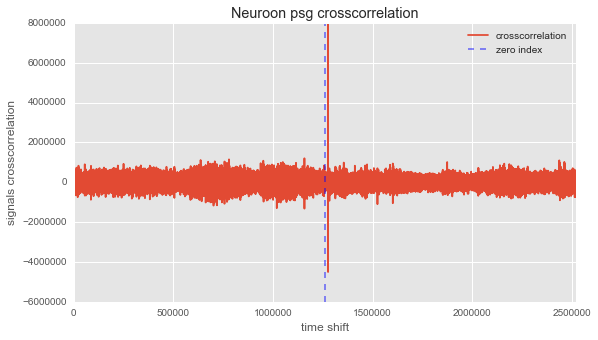

In [6]:
# Look for crosscorrelation of the psg and neuroon signals in night 1
main_crosscorrelation(1)

# 0 samples shift coefficient is stored at the middle column -1.
# shift < 0, or to the right of zero index, means that psg starts 'shift' time steps before neuroon
# shift > 0, or to the left of zero index means that psg starts 'shift' time steps after neuroon

#how max shift is calculated (from the function compute_shift():
#zero_index = int(len(signal) / 2) - 1
#   shift = zero_index - np.argmax(c)

()
max shift at -16061 samples


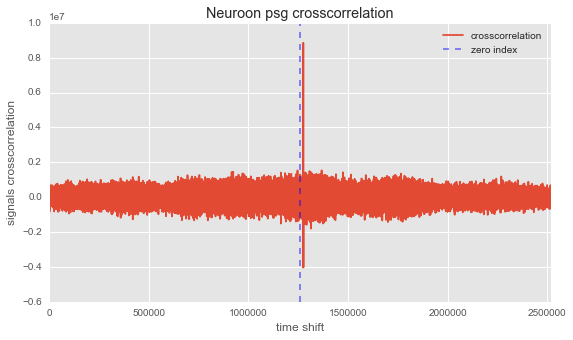

In [7]:
# and night 2
main_crosscorrelation(2)

Conclusion
----------

Crosscorrelation analysis of neuroon and psg signals collected over two nights produced the same results: neuroon clock is offset in respect to psg clock by negative ~ 160 secoonds. In other words psg starts 160 seconds before neuroon.

In [8]:

# Divide the signal into 10 minutes epochs, since we know the maximum of correlation will be included in this window,
# and look for maxima in all epochs
def cross_correlate(night):
    # Load the signal from hdf database and parse it to pandas series with datetime index
    psg_signal =  load_psg('F3-A2', night = night)
    neuroon_signal =  load_neuroon(night = night)
    # Resample the signal to 100hz, to have the same length for cross correlation
    psg_10 = psg_signal.resample('10ms').mean()
    neuroon_10 = neuroon_signal.resample('10ms').mean()
    
    # Create ten minute intervals
    dates_range = pd.date_range(psg_signal.head(1).index.get_values()[0], neuroon_signal.tail(1).index.get_values()[0], freq="10min")
    
    # Convert datetime interval boundaries to string with only hours, minutes and seconds
    dates_range = [d.strftime('%H:%M:%S') for d in dates_range]
    
    
    all_coefs = []
    
    #  iterate over overlapping pairs of 10 minutes boundaries and cut epochs from the signal
    for start, end in pairwise(dates_range):
        # cut 10 minute epochs from the signal
        neuroon_cut = neuroon_10.between_time(start, end)
        psg_cut = psg_10.between_time(start, end)
        
        # Compute the correlation using fft convolution
        shift, coeffs = compute_shift(neuroon_cut, psg_cut)
        #normalize the coefficients because they will be shown on the same heatmap and need a common color scale
        all_coefs.append((coeffs - coeffs.mean()) / coeffs.std())
        
        #print('max corr at shift %s is at sample %i with raw value %i'%(start, shift, max(coeffs)))

    all_coefs = np.array(all_coefs)
    return all_coefs, dates_range

# This function is used to iterate over a list, taking two consecutive items at each iteration
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [ ]:
from plotting_collection import plot_crosscorrelation_heatmap



# Closer look at crosscorrelation in 10 minutes epochs for night 1
coeffs_matrix, dates = cross_correlate(1)
#Plot part of the coefficients matrix centered around the max average correlation for all 10 minute windows
plot_crosscorrelation_heatmap(coeffs_matrix, dates, window = 500)

* At 04:49:48 an additional 1 second lag appeared. This means the signal cannot be simply shifted by a single constant.
* The lag is not constant, however it increases barely noticeabely by less than a 100ms from the first to the fifth hour of the recording.

In [ ]:
# Closer look at crosscorrelation in 10 minutes epochs for night 2

coeffs_matrix, dates = cross_correlate(2)
#Plot part of the coefficients matrix centered around the max average correlation for all 10 minute windows
plot_crosscorrelation_heatmap(coeffs_matrix, dates, window = 500)

* During the second night the offset value was confirmed.
* The additional 1 second lapse towards the end of the night did not appear.

In [ ]:
# Now lets try plotting the signals with and without the time shift to see if the shift can be seen
# No need to resample now, plotting against the datetime index will align the signals
psg_signal = load_psg('F3-A2', night =1)
neuroon_signal = load_neuroon(night = 1)

# Get the time where we know the correlation was strong
start = '03:52:10'
end = '03:52:20'

# Downsample signal to smoothen it and so bigger window can be shown on the plot while still readable
neuroon_cut = neuroon_signal.between_time(start, end).resample('100ms').mean().as_matrix()
psg_cut = psg_signal.between_time(start, end).resample('100ms').mean().as_matrix()

# Normalize the signal to plot it on the same scale
neuroon_cut = (neuroon_cut - neuroon_cut.mean()) / neuroon_cut.std()
psg_cut = (psg_cut - psg_cut.mean()) / psg_cut.std()

fig, axes = plt.subplots(2)
# Plot the original signal
axes[0].plot(neuroon_cut, color = 'r', alpha = 0.5, label = 'neuroon')
axes[0].plot(psg_cut, color = 'b', alpha = 0.5, label = 'psg')
axes[0].legend(loc = 'upper left')
axes[0].set_ylabel('original')


# Shift the signal by number of samples identified in cross correlation. Use the same shift freq as in crosscorrelation
neuroon_cut2 = neuroon_signal.shift(-16056, freq = '10ms').between_time(start, end).resample('100ms').mean().as_matrix()
psg_cut2 = psg_signal.between_time(start, end).resample('100ms').mean().as_matrix()
# Normalize
neuroon_cut2 = (neuroon_cut2 - neuroon_cut2.mean()) / neuroon_cut2.std()
psg_cut2 = (psg_cut2 - psg_cut2.mean()) / psg_cut2.std()

#Plot the time shifted signal
axes[1].plot(neuroon_cut2, color = 'r', alpha = 0.5)
axes[1].plot(psg_cut2, color = 'b', alpha = 0.5)
axes[1].set_ylabel('neuroon shifted')

for ax in axes:
    ax.set_ylim(-4,4)
    ax.set_xticklabels([])   
    ax.set_yticklabels([])    



Hipnogram time-delay
--------------------
From the crosscorrelation of the eeg signals we can see the two devices are off by 2 minutes 41 seconds. Now we'll see if there is a point in time where the hipnograms are most simmilar. The measure of hipnogram simmilarity will be the sum of times when two devices classified the same sleep stage.


In [ ]:
import parse_hipnogram as ph

# load and parse the hipnograms
neuroon_hipnogram = ph.parse_neuroon_stages()
psg_hipnogram = ph.parse_psg_stages()

# plot the hipnograms
fig, axes = plt.subplots()

axes.plot(neuroon_hipnogram.index, neuroon_hipnogram['stage_num'], color = 'r', alpha = 0.5, label ='neuroon')
axes.plot(psg_hipnogram.index, psg_hipnogram['stage_num'], color = 'b', alpha = 0.5, label ='psg')

axes.legend(loc = 'lower left')
axes.set_yticks([1,2,3,4,5])
axes.set_yticklabels(['rem','N1', 'N2', 'N3','wake'])
axes.set_title('Hipnograms')



# Calculate the time the two hipnograms are indicating the same sleep stage. 
# Repeat for different time shift of neuroon hipnogram.
def intersect_with_shift(min_shift = -500, max_shift = 100):
    
    # Load and parse the hipnograms to a common format
    psg_hipnogram = ph.parse_psg_stages(night = 1)
    neuroon_hipnogram = ph.parse_neuroon_stages(night = 1)
    
    # Prepare a dict to save times where hipnograms were indicating the same stage 
    # Do not include N! since neuroon does not classify it
    intersection = OrderedDict([('wake', []), ('rem',[]), ('N2',[]), ('N3', []), ('stages_sum', [])])
    
    # Define the shift in seconds to move the neuroon hipnogram by
    shift_range = np.arange(-500, 100, 10)
    
    # Iterate and save intersection (i.e. overlap) times per time shift
    for shift in shift_range:
        # copy the hipnograms so the originals don't get time shifted (pass by reference)
        sums, _, _ = get_hipnogram_intersection(neuroon_hipnogram.copy(), psg_hipnogram.copy(), shift)
        
        for stage, intersect_dur in sums.items():
            # By appending to the intersection dict (dict of lists) we keep the list index mapped to shift value
            intersection[stage].append(intersect_dur)
    
    return intersection, shift_range

# Show how hipnogram is organized
# Most important columns are:
# 'stage_shift': str, either start or end. After 'get_hipnogram_intersection()' can be also inside
    # This marks onset and offset of a stage recorded by the device
# 'stage_num': int, code of the sleep stage
psg_hipnogram.head(6)

From a brief inspection we can see that:
* neuroon never identified stage N1
* neuroon had a smaller frequency of changing between sleep stages
* neuroon in mostly identified sleep stage to be N2


In [ ]:
# Perhaps throw this cell out to a script

# this function computes the intersection (i.e. overlap) between two hipnograms. 
# It is equivalent to subtracting one hipnogram from another and finding where the result of the subtraction equals 0

# When shift != 0 then the intersection is calculated with time shift.
def get_hipnogram_intersection(neuroon_hipnogram, psg_hipnogram, time_shift):
    # Shift the hipnogram by time in seconds defined by 'time_shift' (can be negative) 
    neuroon_hipnogram.index = neuroon_hipnogram.index + timedelta(seconds = int(time_shift))
    
    # Join the two hipnograms. 
    # Because they are indexed with datetime the join will insert the rows of neuroon inbetween psg hipnograms
    # in the corresponding times.
    # Joining keeps original columns from both data frames
    # new rows with nans in one of two original sets of columns will be inserted where indexes do not overlap (which is everywhere)
    combined = psg_hipnogram.join(neuroon_hipnogram, how = 'outer', lsuffix = '_psg', rsuffix = '_neuro')
    
    # These nan rows will always occur between start and end of a sleep stage, so can be filled used bfill or ffill.
    combined.loc[:, ['stage_num_psg', 'stage_name_psg', 'stage_num_neuro', \
                     'stage_name_neuro','event_number_psg', 'event_number_neuro']] = \
                combined.loc[:, ['stage_num_psg', 'stage_name_psg', 'stage_num_neuro', \
                                 'stage_name_neuro', 'event_number_psg', 'event_number_neuro']]\
                                .fillna( method = 'bfill')        
    # Mark when a sleep stage defined by start and end gets new rows inserted inbetween.
    # New rows are inserted when inbetween of start and end of stage recorded by one device, another device recorded start or end of a sleep stage
    combined.loc[:, ['stage_shift_psg', 'stage_shift_neuro']] = \
                combined.loc[:, ['stage_shift_psg', 'stage_shift_neuro']].fillna( value = 'inside')      
    
    # From the sleep stage identified by psg subtract the sleep stage according to neuroon.
    combined['overlap'] = combined['stage_num_psg'] - combined['stage_num_neuro']
    
    # Find rows where two devices identified the same stage
    same_stage = combined.loc[combined['overlap'] == 0]
    # Mark each occurence of same stage period with unique id number (event union)
    same_stage.loc[:, 'event_union'] = same_stage['event_number_psg'] + same_stage['event_number_neuro']
    
    # prepare dict to save a list of all overlaps durations per stage (key)
    all_durations = OrderedDict()
    
    # groupby event union, which will result in a dataframe with two rows,
    # first row is the startt and second row is the end of the overlap event.
    for stage_name, intersection in same_stage.groupby('event_union'):
            
            # Subtract the first row timestamp from the last to get the duration. 
            # Store as the duration in seconds.
            duration = (intersection.index.to_series().iloc[-1]- intersection.index.to_series().iloc[0])\
            .total_seconds()
            
            # get at which stage overlap happened                    
            stage_id = intersection.iloc[0, intersection.columns.get_loc('stage_name_neuro')] 
            
            # Keep appending overlap durations to a list stored in a dict. Check if the list exists, if not create it.
            if stage_id not in all_durations.keys():
                all_durations[stage_id] = [duration]
                
            else:   
                all_durations[stage_id].append(duration)
            

    # Calculate some statistics of the overlaps
    means = OrderedDict()
    stds = OrderedDict()
    sums = OrderedDict()
    stages_sum = 0
    
    #Adding it here so it is first item in ordered dict thus plotted on the left end.
    sums['stages_sum'] = 0
    # iterate over lists of overlap durations stored under stage name keys
    for key, value in all_durations.items():
        # Compute their statistics
        means[key] = np.array(value).mean()
        stds[key] = np.array(value).std()
        sums[key] = np.array(value).sum()
        # And the sum from all stages (i.e. not split between stages)
        stages_sum += np.array(value).sum()   
    
    sums['stages_sum'] = stages_sum
    
    return sums, means, stds

In [ ]:
# Calculate the intersection at different time shifts
intersection, shift_range = intersect_with_shift()

In [ ]:
from plotting_collection import plot_intersection
plot_intersection(intersection, shift_range)

Hipnogram analysis indicates the same direction of time delay - psg is 4 minutes 10 seconds before neuroon. The time delay is larger for the hipnograms than for the signals by 1 minute 30 seconds.
Now lets see if the offset can be seen on a closer look to hipnograms.





In [11]:
max_overlap = shift_range[np.argmax(intersection['stages_sum'])]
max_overlap

-250

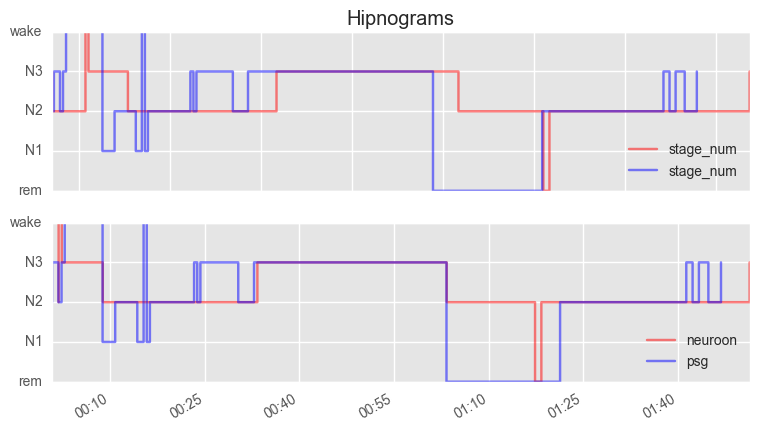

In [14]:
# Compare the hipnograms with the identified time shift
fig, axes = plt.subplots(2)
axes[0].set_title('Hipnograms')

start = '00:00'
end = '02:00'

# Load the original hipnograms
neuroon_hipnogram = ph.parse_neuroon_stages()
psg_hipnogram = ph.parse_psg_stages()

# Select a time window
neuroon_cut = neuroon_hipnogram.between_time(start, end)
psg_cut = psg_hipnogram.between_time(start, end)


# plot the original hipnograms
axes[0].plot(neuroon_cut.index, neuroon_cut['stage_num'], color = 'r', alpha = 0.5)
axes[0].plot(psg_cut.index, psg_cut['stage_num'], color = 'b', alpha = 0.5)

# Repeat for the time shifted hipnograms
# Identify the max shift
max_overlap = shift_range[np.argmax(intersection['stages_sum'])]

# parse the hipnogram and add the time shift
neuroon_hipnogram = ph.parse_neuroon_stages(permute = False,time_shift = max_overlap)
psg_hipnogram = ph.parse_psg_stages()

neuroon_cut = neuroon_hipnogram.between_time(start, end)
psg_cut = psg_hipnogram.between_time(start, end)

# Plot the shifted
axes[1].plot(neuroon_cut.index, neuroon_cut['stage_num'], color = 'r', alpha = 0.5, label ='neuroon')
axes[1].plot(psg_cut.index, psg_cut['stage_num'], color = 'b', alpha = 0.5, label ='psg')

# Format the figure
for ax in axes:
    ax.legend(loc = 'lower right')
    ax.set_yticks([1,2,3,4,5])
    ax.set_yticklabels(['rem','N1', 'N2', 'N3','wake'])
    ax.xaxis.set_major_formatter( DateFormatter('%H:%M') )

fig.autofmt_xdate()



Conclusion
----------

* The neuroon eeg signal has a time delay in respect to psg of 2 min 40 sec. This delay is most likely due to unsycnchronized clocks between two recording devices, thus is expectable.
* The neuroon hypnogram has a time delay of 4 min 10 seconds which is and additional 1 min 30 sec to what has been observed in eeg signals. This 1 min 30 sec delay cannot be explained by clock synchronization and is likely to originate from requirements of real time staging algorithm, for example collecting enough data points to perform fourier transform of the signal.
* The hipnogram analysis will be performed using the time delay identified in eeg signnals cross correlation.

Todo: 
* add different correlation tests notebook
* add spectral and pca analysis
* Docstrings for scripts (not notebooks)